In [0]:
import os
import re
import sys
import time
import random
import math
import string
import copy
import pickle
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1332

In [0]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batchsize, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batchsize, shuffle=True)

In [0]:
class dropout(nn.Module):
  def __init__(self,dropprob):
    super(dropout,self).__init__()
    self.dropprob = dropprob
  def forward(self,X,trainmode):
    if(trainmode):
      dropweights = torch.distributions.binomial.Binomial(probs=1-self.dropprob).sample(X.size()).to(device)
      return X * dropweights * 1/(1-self.dropprob)
    return X

In [0]:
class ModelWithCustomDropout(nn.Module):
  def __init__(self):
    super(ModelWithCustomDropout,self).__init__()
    self.fc1 = nn.Linear(784,300)
    self.drop1 = dropout(0.4)
    self.fc2 = nn.Linear(300,64)
    self.drop2 = dropout(0.3)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self,x,mode):
    out = F.relu(self.fc1(x))
    out = self.drop1(out,mode)
    out = F.relu(self.fc2(out))
    out = self.drop2(out,mode)
    out = self.fc3(out)
    return out

In [0]:
def metrics_custom(net,loader):
  trainmode = False
  with torch.no_grad():
    correct = 0.0
    total = 0.0
    epochloss = 0.0
    for Xtrain,ytrain in loader:
      Xtrain = Xtrain.view(Xtrain.size(0),-1).to(device)
      ytrain = ytrain.to(device)

      output = net(Xtrain,trainmode)
      curloss =  F.cross_entropy(output,ytrain,reduction='sum')
      epochloss+=curloss.item()
      
      _,predictions = torch.max(output,1)
      correct+=torch.sum(predictions==ytrain).item()
      total+=Xtrain.size(0)

    return round((epochloss/total),3),round(((correct/total)*100),2)

In [0]:
numepochs = 30

In [56]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

net1 = ModelWithCustomDropout().to(device)
optimizer = optim.Adam(net1.parameters())

train_acc_custom = []
train_loss_custom = []
test_acc_custom = []

for epoch in range(numepochs):
  trainmode = True
  for data,labels in train_loader:
      data = data.to(device).view(data.size(0),-1)
      labels = labels.to(device)
      
      net1.zero_grad()
      output = net1(data,trainmode)
      loss = F.cross_entropy(output,labels)
      
      train_loss_custom.append(loss.item())

      loss.backward()
      optimizer.step()

  train_loss,train_acc = metrics_custom(net1,train_loader)
  test_loss,test_acc = metrics_custom(net1,test_loader)
  test_acc_custom.append(test_acc)
  train_acc_custom.append(train_acc)

  print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch+1,train_acc,test_acc))

Epoch 1 Train Accuracy 96.13 Test Accuracy 96.06
Epoch 2 Train Accuracy 97.56 Test Accuracy 97.17
Epoch 3 Train Accuracy 97.71 Test Accuracy 97.14
Epoch 4 Train Accuracy 98.38 Test Accuracy 97.76
Epoch 5 Train Accuracy 98.38 Test Accuracy 97.73
Epoch 6 Train Accuracy 98.57 Test Accuracy 97.84
Epoch 7 Train Accuracy 98.95 Test Accuracy 98.14
Epoch 8 Train Accuracy 98.86 Test Accuracy 97.87
Epoch 9 Train Accuracy 98.94 Test Accuracy 97.85
Epoch 10 Train Accuracy 99.0 Test Accuracy 97.93
Epoch 11 Train Accuracy 99.02 Test Accuracy 97.88
Epoch 12 Train Accuracy 99.05 Test Accuracy 97.96
Epoch 13 Train Accuracy 99.22 Test Accuracy 97.92
Epoch 14 Train Accuracy 99.41 Test Accuracy 97.95
Epoch 15 Train Accuracy 99.32 Test Accuracy 98.04
Epoch 16 Train Accuracy 99.37 Test Accuracy 98.17
Epoch 17 Train Accuracy 99.32 Test Accuracy 97.96
Epoch 18 Train Accuracy 99.38 Test Accuracy 98.13
Epoch 19 Train Accuracy 99.5 Test Accuracy 98.23
Epoch 20 Train Accuracy 99.49 Test Accuracy 98.12
Epoch 21 Tr

In [0]:
class ModelWithPyTorchDropout(nn.Module):
  def __init__(self):
    super(ModelWithPyTorchDropout,self).__init__()
    self.fc1 = nn.Linear(784,300)
    self.drop1 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(300,64)
    self.drop2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self,x):
    out = F.relu(self.fc1(x))
    out = self.drop1(out)
    out = F.relu(self.fc2(out))
    out = self.drop2(out)
    out = self.fc3(out)
    return out

In [0]:
def metrics_normal(net,loader):
  with torch.no_grad():
    net.eval()
    correct = 0.0
    total = 0.0
    epochloss = 0.0
    for Xtrain,ytrain in loader:
      Xtrain = Xtrain.view(Xtrain.size(0),-1).to(device)
      ytrain = ytrain.to(device)

      output = net(Xtrain)
      curloss =  F.cross_entropy(output,ytrain,reduction='sum')
      epochloss+=curloss.item()
      
      _,predictions = torch.max(output,1)
      correct+=torch.sum(predictions==ytrain).item()
      total+=Xtrain.size(0)

    return round((epochloss/total),3),round(((correct/total)*100),2)

In [59]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

net2 = ModelWithPyTorchDropout().to(device)
optimizer = optim.Adam(net2.parameters())

train_acc_normal = []
train_loss_normal = []
test_acc_normal = []

net2.train()
for epoch in range(numepochs):
  net2.train()
  for data,labels in train_loader:
      data = data.to(device).view(data.size(0),-1)
      labels = labels.to(device)
      
      net2.zero_grad()
      output = net2(data)
      loss = F.cross_entropy(output,labels)
      
      train_loss_normal.append(loss.item())

      loss.backward()
      optimizer.step()

  train_loss,train_acc = metrics_normal(net2,train_loader)
  test_loss,test_acc = metrics_normal(net2,test_loader)
  test_acc_normal.append(test_acc)
  train_acc_normal.append(train_acc)

  print("Epoch {} Train Accuracy {} Test Accuracy {}".format(epoch+1,train_acc,test_acc))

Epoch 1 Train Accuracy 96.06 Test Accuracy 96.05
Epoch 2 Train Accuracy 97.15 Test Accuracy 96.69
Epoch 3 Train Accuracy 97.69 Test Accuracy 97.16
Epoch 4 Train Accuracy 98.04 Test Accuracy 97.28
Epoch 5 Train Accuracy 98.47 Test Accuracy 97.77
Epoch 6 Train Accuracy 98.73 Test Accuracy 97.63
Epoch 7 Train Accuracy 98.62 Test Accuracy 97.49
Epoch 8 Train Accuracy 98.76 Test Accuracy 97.8
Epoch 9 Train Accuracy 99.04 Test Accuracy 97.97
Epoch 10 Train Accuracy 98.98 Test Accuracy 97.91
Epoch 11 Train Accuracy 99.13 Test Accuracy 98.04
Epoch 12 Train Accuracy 99.16 Test Accuracy 97.92
Epoch 13 Train Accuracy 99.18 Test Accuracy 97.93
Epoch 14 Train Accuracy 99.3 Test Accuracy 97.99
Epoch 15 Train Accuracy 99.33 Test Accuracy 98.14
Epoch 16 Train Accuracy 99.35 Test Accuracy 98.18
Epoch 17 Train Accuracy 99.44 Test Accuracy 98.25
Epoch 18 Train Accuracy 99.48 Test Accuracy 98.16
Epoch 19 Train Accuracy 99.3 Test Accuracy 98.01
Epoch 20 Train Accuracy 99.44 Test Accuracy 98.05
Epoch 21 Tra

In [0]:
iterations = range(numepochs)

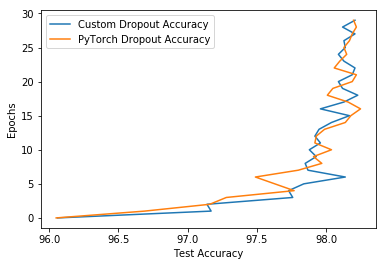

In [61]:
plt.plot(test_acc_custom,iterations,label='Custom Dropout Accuracy')
plt.plot(test_acc_normal,iterations,label='PyTorch Dropout Accuracy')
plt.xlabel('Test Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.show()

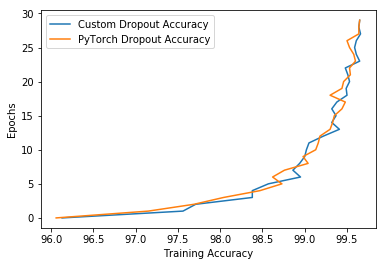

In [62]:
plt.plot(train_acc_custom,iterations,label='Custom Dropout Accuracy')
plt.plot(train_acc_normal,iterations,label='PyTorch Dropout Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.show()

In [0]:
batches = range(len(train_loss_custom))

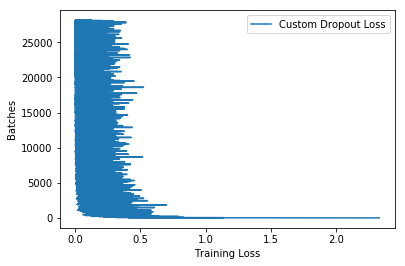

In [67]:
plt.plot(train_loss_custom,batches,label='Custom Dropout Loss')
#plt.plot(train_loss_normal,batches,label='PyTorch Dropout Loss')
plt.xlabel('Training Loss')
plt.ylabel('Batches')
plt.legend()
plt.show()

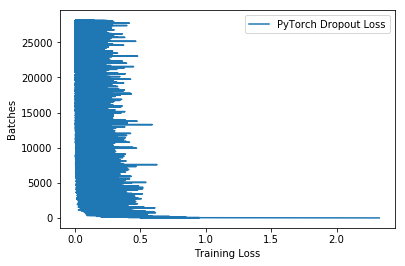

In [65]:
plt.plot(train_loss_normal,batches,label='PyTorch Dropout Loss')
plt.xlabel('Training Loss')
plt.ylabel('Batches')
plt.legend()
plt.show()